In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.preprocessing import MinMaxScaler
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import mean_squared_error
from math import sqrt
import itertools
import warnings
warnings.filterwarnings('ignore')
from prophet import Prophet
from sklearn.metrics import mean_squared_error
import numpy as np
from tensorflow.keras.utils import plot_model
import logging
logging.getLogger('prophet').setLevel(logging.ERROR)
logging.getLogger('cmdstanpy').setLevel(logging.ERROR)

In [112]:
from tensorflow import random
random.set_seed(0)

# Data Loading

In [113]:
# Load the data
data = pd.read_excel('/content/drive/My Drive/Colab Notebooks/微众实习/Shibor_LPR_国债相关利率数据.xlsx')
data.set_index('日期', inplace=True)

# 删除'市场询价利率(6M)'缺失值
data.dropna(subset=['市场询价利率(6M)'], inplace=True)

In [114]:
df_trans = data.copy()

# Train-Test-Split

In [115]:
train_size = int(len(df_trans) * 0.6)
val_size = int(len(df_trans) * 0.2)
train, val, test = df_trans.iloc[:train_size].copy(), df_trans.iloc[train_size:train_size+val_size].copy(), df_trans.iloc[train_size+val_size:].copy()

# Feature Engineering

In [116]:
def feature_engineering(df, column_name):
    for lag in range(1, 6):
        df[f'lag_{lag}'] = df[column_name].shift(lag)

    df['rolling_mean_5'] = df[column_name].rolling(window=5).mean().shift(1)
    df['ema_5'] = df[column_name].ewm(span=5).mean().shift(1)
    df['expanding_mean'] = df[column_name].expanding().mean().shift(1)
    df['expanding_std'] = df[column_name].expanding().std().shift(1)
    df['rolling_skew_5'] = df[column_name].rolling(window=5).skew().shift(1)
    df['rolling_kurt_5'] = df[column_name].rolling(window=5).kurt().shift(1)

    result_train = seasonal_decompose(df[column_name], model='additive', period=5, two_sided=False)
    df['trend'] = result_train.trend
    df['seasonal'] = result_train.seasonal

    df.dropna(inplace=True)
    return df

# Train-Validation-Test Split

In [117]:
# Apply feature engineering
train = feature_engineering(train, '市场询价利率(6M)')
val = feature_engineering(val, '市场询价利率(6M)')
test = feature_engineering(test, '市场询价利率(6M)')

In [118]:
correlation = train.corr()['市场询价利率(6M)'].sort_values(ascending=False)
N = 10
selected_features = correlation.abs().sort_values(ascending=False).head(N+1).index[1:]

In [119]:
X_train, y_train = train[selected_features], train['市场询价利率(6M)']
X_val, y_val = val[selected_features], val['市场询价利率(6M)']
X_test, y_test = test[selected_features], test['市场询价利率(6M)']

# Scale the Features and Target Variables

In [120]:
scaler_features = MinMaxScaler()
scaler_target = MinMaxScaler()

X_train_scaled = scaler_features.fit_transform(X_train)
y_train_scaled = scaler_target.fit_transform(y_train.values.reshape(-1, 1))

X_val_scaled = scaler_features.transform(X_val)
y_val_scaled = scaler_target.transform(y_val.values.reshape(-1, 1))

X_test_scaled = scaler_features.transform(X_test)
y_test_scaled = scaler_target.transform(y_test.values.reshape(-1, 1))

# Create Time Series Generators

In [121]:
look_back = 5
batch_size = 6

train_generator = TimeseriesGenerator(X_train_scaled, y_train_scaled, length=look_back, batch_size=batch_size)
val_generator = TimeseriesGenerator(X_val_scaled, y_val_scaled, length=look_back, batch_size=batch_size)
test_generator = TimeseriesGenerator(X_test_scaled, y_test_scaled, length=look_back, batch_size=batch_size)


# Fit Model

## Single Layer LSTM

In [122]:
from keras.regularizers import L1, L2
# Define and compile the model
base_model = Sequential()
base_model.add(LSTM(50, input_shape=(look_back, N)))
base_model.add(Dropout(0.2))
base_model.add(Dense(1))
base_model.compile(optimizer='adam', loss='mse')

# Train the model using the training generator and validate using the validation generator
base_model.fit(train_generator, validation_data=val_generator, epochs=200)

Epoch 1/200
120/120 [==============================] - 4s 11ms/step - loss: 0.0158 - val_loss: 0.0156
Epoch 2/200
120/120 [==============================] - 1s 7ms/step - loss: 0.0061 - val_loss: 0.0159
Epoch 3/200
120/120 [==============================] - 1s 6ms/step - loss: 0.0058 - val_loss: 0.0133
Epoch 4/200
120/120 [==============================] - 1s 7ms/step - loss: 0.0047 - val_loss: 0.0125
Epoch 5/200
120/120 [==============================] - 1s 6ms/step - loss: 0.0041 - val_loss: 0.0123
Epoch 6/200
120/120 [==============================] - 1s 7ms/step - loss: 0.0046 - val_loss: 0.0122
Epoch 7/200
120/120 [==============================] - 1s 9ms/step - loss: 0.0041 - val_loss: 0.0131
Epoch 8/200
120/120 [==============================] - 1s 9ms/step - loss: 0.0039 - val_loss: 0.0118
Epoch 9/200
120/120 [==============================] - 1s 9ms/step - loss: 0.0038 - val_loss: 0.0115
Epoch 10/200
120/120 [==============================] - 1s 7ms/step - loss: 0.0038 - val_l

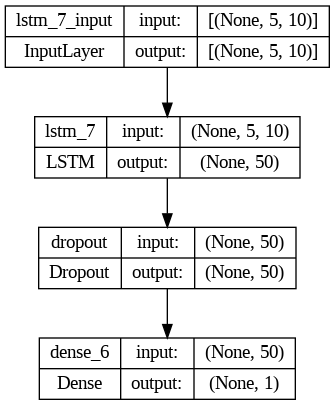

In [40]:
from tensorflow.keras.utils import plot_model
# plot the model structure
plot_model(base_model, to_file='model.png', show_shapes=True, show_layer_names=True)

In [123]:
base_train_predictions = base_model.predict(train_generator)
base_val_predictions = base_model.predict(val_generator)
base_test_predictions = base_model.predict(test_generator)

base_train_rmse = np.sqrt(mean_squared_error(y_train_scaled[look_back:], base_train_predictions))
base_val_rmse = np.sqrt(mean_squared_error(y_val_scaled[look_back:], base_val_predictions))
base_test_rmse = np.sqrt(mean_squared_error(y_test_scaled[look_back:], base_test_predictions))

39/39 [==============================] - 0s 2ms/step


In [124]:
base_rmse_df = pd.DataFrame({
    'Dataset': ['Train', 'Validation', 'Test'],
    'RMSE': [base_train_rmse, base_val_rmse, base_test_rmse]
})

print(base_rmse_df)

      Dataset      RMSE
0       Train  0.031217
1  Validation  0.084129
2        Test  0.083795


In [125]:
import matplotlib.pyplot as plt

# Getting the date index
date_index = df_trans.index

y_train_inv = scaler_target.inverse_transform(y_train_scaled[look_back:])
y_val_inv = scaler_target.inverse_transform(y_val_scaled[look_back:])
y_test_inv = scaler_target.inverse_transform(y_test_scaled[look_back:])

# Create date axes for plotting
train_date_axis = train.index[look_back:]
val_date_axis = val.index[look_back:]
test_date_axis = test.index[look_back:]

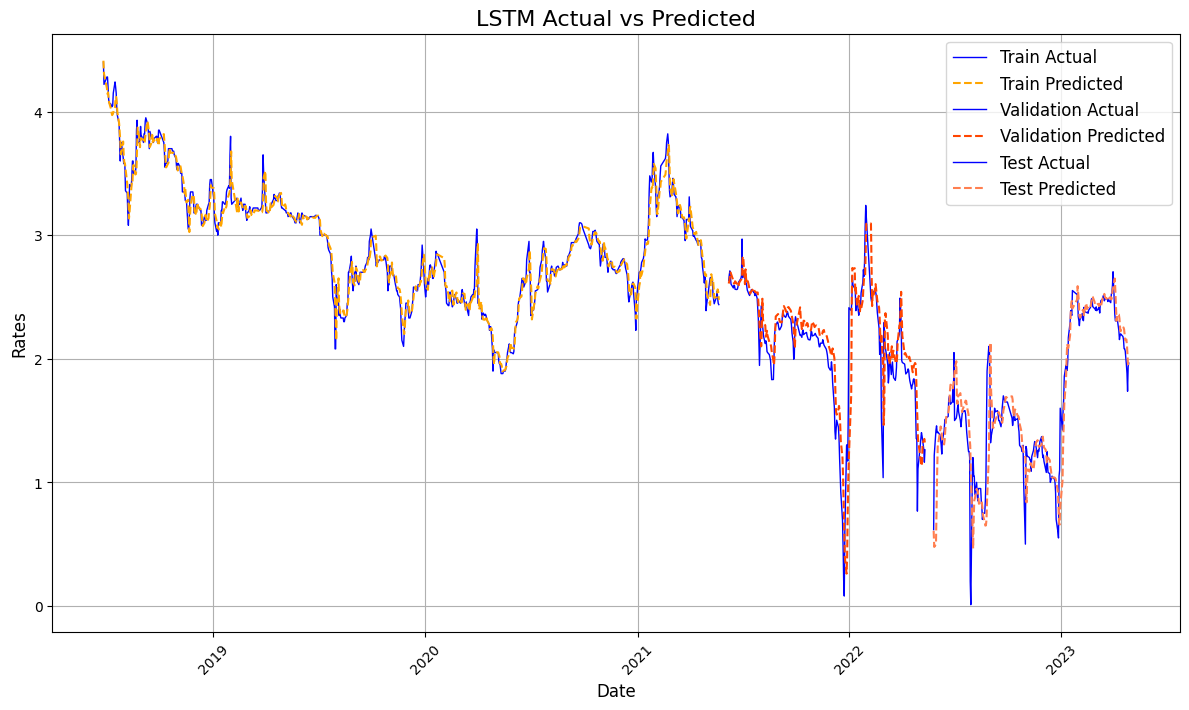

In [126]:
# Invert the scaling of predictions and actual values
base_train_predictions_inv = scaler_target.inverse_transform(base_train_predictions)
base_val_predictions_inv = scaler_target.inverse_transform(base_val_predictions)
base_test_predictions_inv = scaler_target.inverse_transform(base_test_predictions)

# Plotting the actual and predicted values
plt.figure(figsize=(12, 7))

# Train set
plt.plot(train_date_axis, y_train_inv, color='blue', linewidth=1, label='Train Actual')
plt.plot(train_date_axis, base_train_predictions_inv, color='orange', linestyle='dashed', label='Train Predicted')

# Validation set
plt.plot(val_date_axis, y_val_inv, color='blue', linewidth=1, label='Validation Actual')
plt.plot(val_date_axis, base_val_predictions_inv, color='orangered', linestyle='dashed', label='Validation Predicted')

# Test set
plt.plot(test_date_axis, y_test_inv, color='blue', linewidth=1, label='Test Actual')
plt.plot(test_date_axis, base_test_predictions_inv, color='coral', linestyle='dashed', label='Test Predicted')

plt.xlabel('Date', fontsize=12)
plt.ylabel('Rates', fontsize=12)
plt.title('LSTM Actual vs Predicted', fontsize=16)
plt.legend(fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.xticks(rotation=45)  # Rotate the x-axis labels for better visibility
plt.show()

In [129]:
data = {'Index': test_date_axis,'T Acutual': y_test_inv.flatten(),'Prediction': base_test_predictions_inv.flatten()}
df = pd.DataFrame(data)
df
# Save to a CSV file
csv_filename = 'predictionstest.csv'
df.to_csv(csv_filename, index=False)

# Initiate the download
files.download(csv_filename)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Double Layer LSTM

In [48]:
model_lstm = Sequential()
model_lstm.add(LSTM(100, return_sequences=True, input_shape=(look_back, N))) # Increased from 50 to 100 neurons
model_lstm.add(LSTM(50)) # Additional LSTM layer
model_lstm.add(Dropout(0.2))
model_lstm.add(Dense(1))
model_lstm.compile(optimizer='adam', loss='mse')

# Train the model using the training generator and validate using the validation generator
model_lstm.fit(train_generator, validation_data=val_generator, epochs=200)

Epoch 1/200
120/120 [==============================] - 16s 57ms/step - loss: 0.0072 - val_loss: 0.0163
Epoch 2/200
120/120 [==============================] - 4s 31ms/step - loss: 0.0057 - val_loss: 0.0142
Epoch 3/200
120/120 [==============================] - 2s 20ms/step - loss: 0.0060 - val_loss: 0.0144
Epoch 4/200
120/120 [==============================] - 2s 19ms/step - loss: 0.0047 - val_loss: 0.0136
Epoch 5/200
120/120 [==============================] - 2s 19ms/step - loss: 0.0043 - val_loss: 0.0128
Epoch 6/200
120/120 [==============================] - 3s 27ms/step - loss: 0.0048 - val_loss: 0.0125
Epoch 7/200
120/120 [==============================] - 3s 22ms/step - loss: 0.0047 - val_loss: 0.0129
Epoch 8/200
120/120 [==============================] - 2s 18ms/step - loss: 0.0039 - val_loss: 0.0125
Epoch 9/200
120/120 [==============================] - 1s 12ms/step - loss: 0.0045 - val_loss: 0.0113
Epoch 10/200
120/120 [==============================] - 1s 11ms/step - loss: 0.00

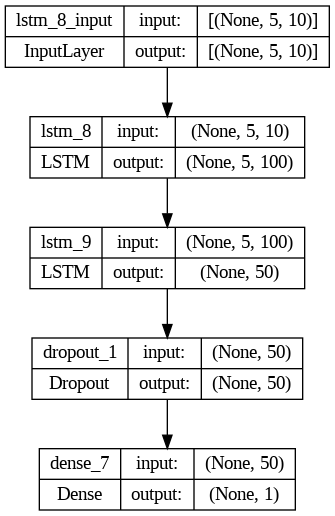

In [49]:
from tensorflow.keras.utils import plot_model
# plot the model structure
plot_model(model_lstm, to_file='model.png', show_shapes=True, show_layer_names=True)

In [50]:
lstm_train_predictions = model_lstm.predict(train_generator)
lstm_val_predictions = model_lstm.predict(val_generator)
lstm_test_predictions = model_lstm.predict(test_generator)

lstm_train_rmse = np.sqrt(mean_squared_error(y_train_scaled[look_back:], lstm_train_predictions))
lstm_val_rmse = np.sqrt(mean_squared_error(y_val_scaled[look_back:], lstm_val_predictions))
lstm_test_rmse = np.sqrt(mean_squared_error(y_test_scaled[look_back:], lstm_test_predictions))

39/39 [==============================] - 0s 3ms/step


In [51]:
lstm_rmse_df = pd.DataFrame({
    'Dataset': ['Train', 'Validation', 'Test'],
    'RMSE': [lstm_train_rmse, lstm_val_rmse, lstm_test_rmse]
})

print(lstm_rmse_df)

      Dataset      RMSE
0       Train  0.025896
1  Validation  0.093046
2        Test  0.105676


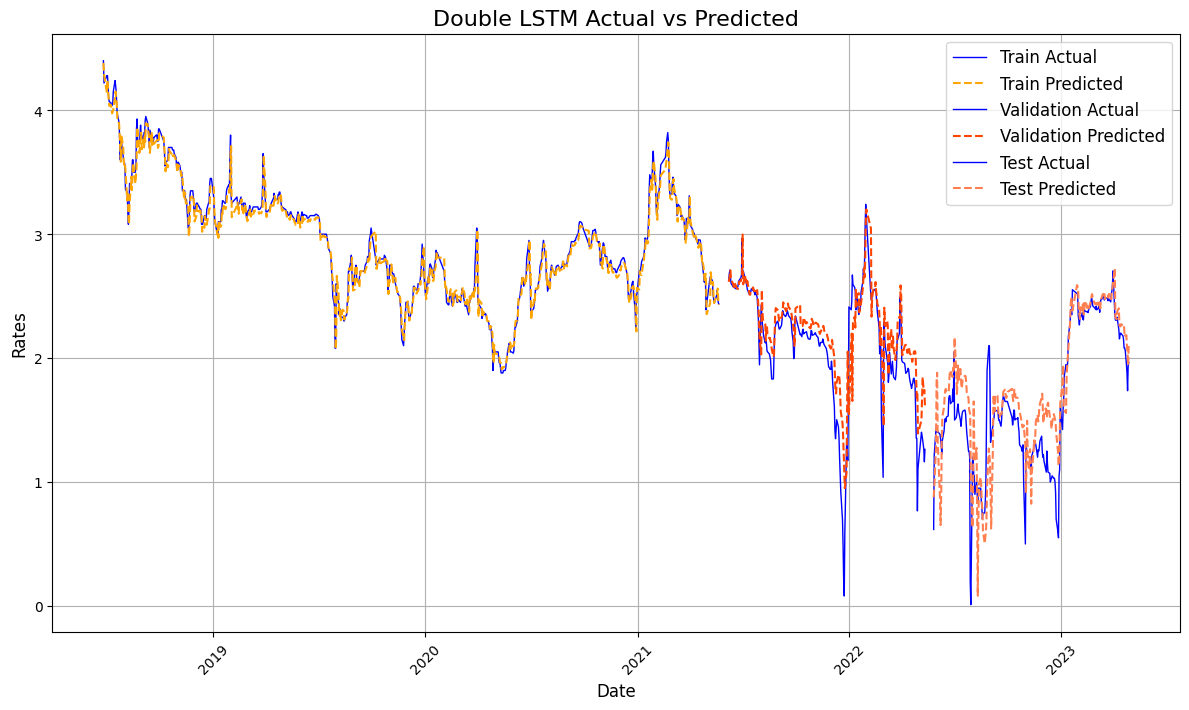

In [52]:
# Invert the scaling of predictions and actual values
lstm_train_predictions_inv = scaler_target.inverse_transform(lstm_train_predictions)
lstm_val_predictions_inv = scaler_target.inverse_transform(lstm_val_predictions)
lstm_test_predictions_inv = scaler_target.inverse_transform(lstm_test_predictions)

# Plotting the actual and predicted values
plt.figure(figsize=(12, 7))

# Train set
plt.plot(train_date_axis, y_train_inv, color='blue', linewidth=1, label='Train Actual')
plt.plot(train_date_axis, lstm_train_predictions_inv, color='orange', linestyle='dashed', label='Train Predicted')

# Validation set
plt.plot(val_date_axis, y_val_inv, color='blue', linewidth=1, label='Validation Actual')
plt.plot(val_date_axis, lstm_val_predictions_inv, color='orangered', linestyle='dashed', label='Validation Predicted')

# Test set
plt.plot(test_date_axis, y_test_inv, color='blue', linewidth=1, label='Test Actual')
plt.plot(test_date_axis, lstm_test_predictions_inv, color='coral', linestyle='dashed', label='Test Predicted')

plt.xlabel('Date', fontsize=12)
plt.ylabel('Rates', fontsize=12)
plt.title('Double LSTM Actual vs Predicted', fontsize=16)
plt.legend(fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.xticks(rotation=45)  # Rotate the x-axis labels for better visibility
plt.show()


## GRU

In [55]:
from keras.layers import GRU

model_gru = Sequential()
model_gru.add(GRU(100, return_sequences=True, input_shape=(look_back, N)))
model_gru.add(GRU(50))
model_gru.add(Dropout(0.2))
model_gru.add(Dense(1))
model_gru.compile(optimizer='adam', loss='mse')

# Train the model using the training generator and validate using the validation generator
model_gru.fit(train_generator, validation_data=val_generator, epochs=200)

Epoch 1/200
120/120 [==============================] - 8s 18ms/step - loss: 0.0153 - val_loss: 0.0126
Epoch 2/200
120/120 [==============================] - 1s 12ms/step - loss: 0.0055 - val_loss: 0.0138
Epoch 3/200
120/120 [==============================] - 1s 11ms/step - loss: 0.0049 - val_loss: 0.0113
Epoch 4/200
120/120 [==============================] - 2s 17ms/step - loss: 0.0052 - val_loss: 0.0107
Epoch 5/200
120/120 [==============================] - 2s 16ms/step - loss: 0.0041 - val_loss: 0.0118
Epoch 6/200
120/120 [==============================] - 1s 11ms/step - loss: 0.0038 - val_loss: 0.0101
Epoch 7/200
120/120 [==============================] - 1s 11ms/step - loss: 0.0042 - val_loss: 0.0098
Epoch 8/200
120/120 [==============================] - 1s 11ms/step - loss: 0.0035 - val_loss: 0.0104
Epoch 9/200
120/120 [==============================] - 1s 11ms/step - loss: 0.0046 - val_loss: 0.0102
Epoch 10/200
120/120 [==============================] - 2s 13ms/step - loss: 0.003

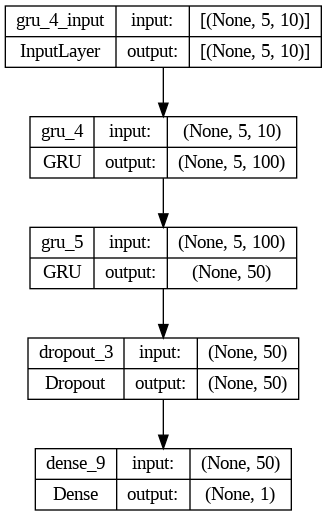

In [56]:
from tensorflow.keras.utils import plot_model
# plot the model structure
plot_model(model_gru, to_file='model.png', show_shapes=True, show_layer_names=True)

In [57]:
gru_train_predictions = model_gru.predict(train_generator)
gru_val_predictions = model_gru.predict(val_generator)
gru_test_predictions = model_gru.predict(test_generator)

gru_train_rmse = np.sqrt(mean_squared_error(y_train_scaled[look_back:], gru_train_predictions))
gru_val_rmse = np.sqrt(mean_squared_error(y_val_scaled[look_back:], gru_val_predictions))
gru_test_rmse = np.sqrt(mean_squared_error(y_test_scaled[look_back:], gru_test_predictions))

39/39 [==============================] - 0s 3ms/step


In [58]:
gru_rmse_df = pd.DataFrame({
    'Dataset': ['Train', 'Validation', 'Test'],
    'RMSE': [gru_train_rmse, gru_val_rmse, gru_test_rmse]
})

print(gru_rmse_df)

      Dataset      RMSE
0       Train  0.025502
1  Validation  0.070370
2        Test  0.073317


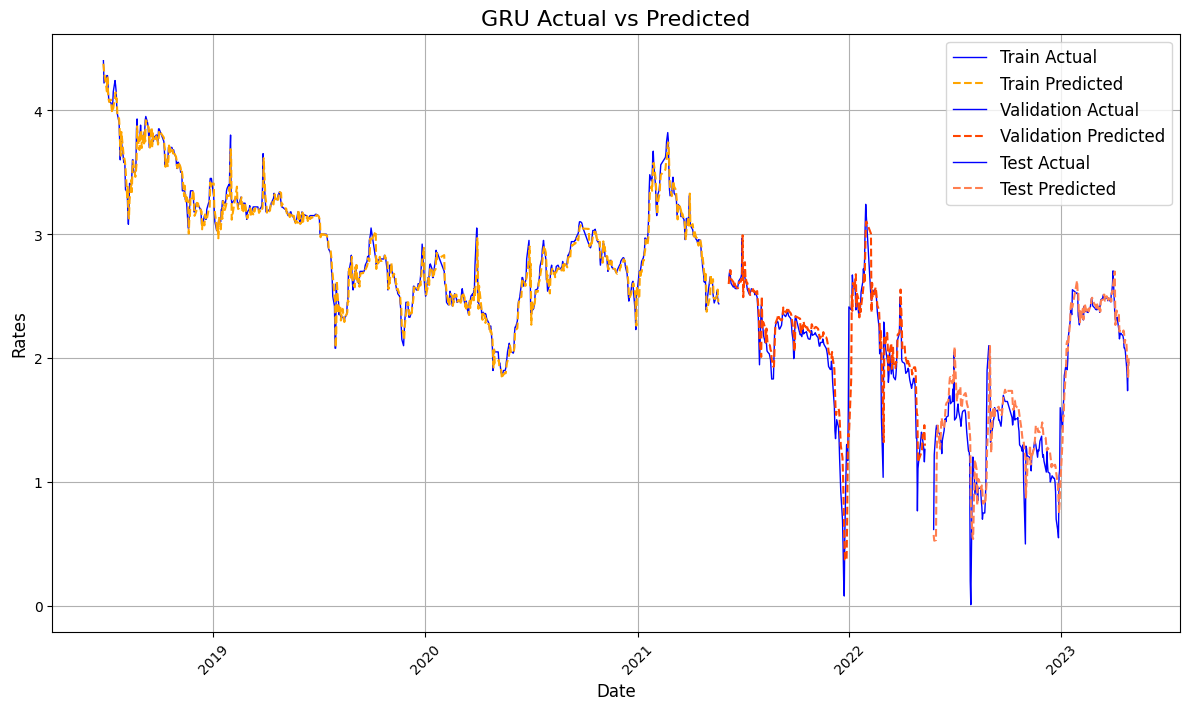

In [59]:
# Invert the scaling of predictions and actual values
gru_train_predictions_inv = scaler_target.inverse_transform(gru_train_predictions)
gru_val_predictions_inv = scaler_target.inverse_transform(gru_val_predictions)
gru_test_predictions_inv = scaler_target.inverse_transform(gru_test_predictions)

# Plotting the actual and predicted values
plt.figure(figsize=(12, 7))

# Train set
plt.plot(train_date_axis, y_train_inv, color='blue', linewidth=1, label='Train Actual')
plt.plot(train_date_axis, gru_train_predictions_inv, color='orange', linestyle='dashed', label='Train Predicted')

# Validation set
plt.plot(val_date_axis, y_val_inv, color='blue', linewidth=1, label='Validation Actual')
plt.plot(val_date_axis, gru_val_predictions_inv, color='orangered', linestyle='dashed', label='Validation Predicted')

# Test set
plt.plot(test_date_axis, y_test_inv, color='blue', linewidth=1, label='Test Actual')
plt.plot(test_date_axis, gru_test_predictions_inv, color='coral', linestyle='dashed', label='Test Predicted')

plt.xlabel('Date', fontsize=12)
plt.ylabel('Rates', fontsize=12)
plt.title('GRU Actual vs Predicted', fontsize=16)
plt.legend(fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.xticks(rotation=45)  # Rotate the x-axis labels for better visibility
plt.show()


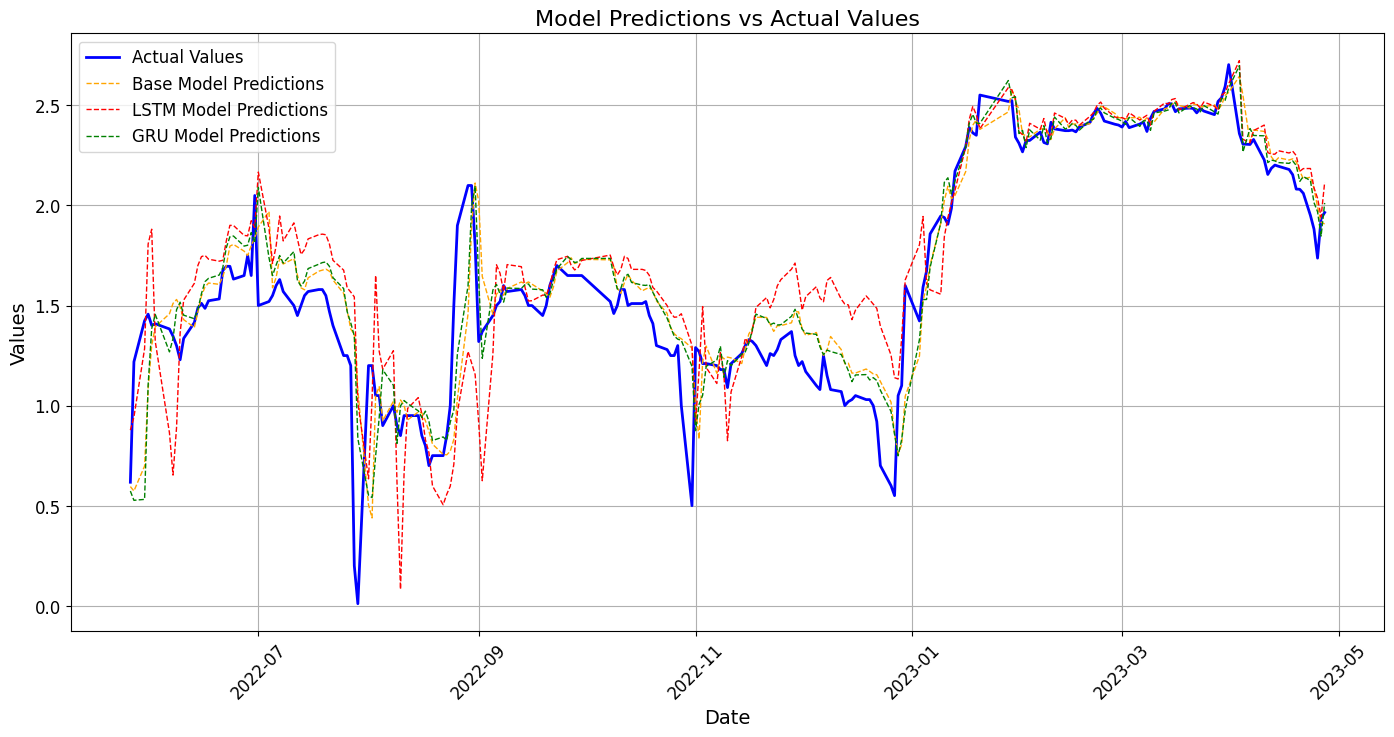

In [60]:
plt.figure(figsize=(14, 7))

# Plot the actual values
plt.plot(test_date_axis, y_test_inv, color='blue', linewidth=2, label='Actual Values')

# Plot the predictions from the base model
plt.plot(test_date_axis, base_test_predictions_inv, color='orange', linestyle='dashed', linewidth=1, label='Base Model Predictions')

# Plot the predictions from the LSTM model
plt.plot(test_date_axis, lstm_test_predictions_inv, color='red', linestyle='dashed', linewidth=1, label='LSTM Model Predictions')

# Plot the predictions from the GRU model
plt.plot(test_date_axis, gru_test_predictions_inv, color='green', linestyle='dashed', linewidth=1, label='GRU Model Predictions')

# Adding labels and title
plt.xlabel('Date', fontsize=14)
plt.ylabel('Values', fontsize=14)
plt.title('Model Predictions vs Actual Values', fontsize=16)

# Adding a legend to differentiate between the lines
plt.legend(fontsize=12)

# Display the plot
plt.grid(True)
plt.tight_layout()
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.show()


# 30 Days Prediction

# Data Loading

In [62]:
# Load the data
data = pd.read_excel('/content/drive/My Drive/Colab Notebooks/微众实习/predict30.xlsx')
data.set_index('日期', inplace=True)

# 删除'市场询价利率(6M)'缺失值
data.dropna(subset=['市场询价利率(6M)'], inplace=True)

In [63]:
df_trans = data.copy()

# Train-Test-Split

In [64]:
train_size = int(len(df_trans) * 0.6)
val_size = int(len(df_trans) * 0.2)
train_30, val_30, test_30 = df_trans.iloc[:train_size].copy(), df_trans.iloc[train_size:train_size+val_size].copy(), df_trans.iloc[train_size+val_size:].copy()

# Train-Validation-Test Split

In [65]:
# Apply feature engineering
train_30 = feature_engineering(train_30, '市场询价利率(6M)')
val_30 = feature_engineering(val_30, '市场询价利率(6M)')
test_30 = feature_engineering(test_30, '市场询价利率(6M)')

In [66]:
correlation = train_30.corr()['市场询价利率(6M)'].sort_values(ascending=False)
N = 10
selected_features = correlation.abs().sort_values(ascending=False).head(N+1).index[1:]

In [67]:
correlation = train_30.corr()['市场询价利率(6M)'].sort_values(ascending=False)
print(correlation)

市场询价利率(6M)        1.000000
lag_1             0.987570
trend             0.982591
ema_5             0.975895
lag_2             0.970412
rolling_mean_5    0.969387
lag_3             0.956304
lag_4             0.945205
lag_5             0.935575
expanding_mean    0.732345
10年期国债收益率         0.715690
1Y                0.691821
9M                0.682280
6M                0.672695
3M                0.635958
1M                0.608440
1年期国债收益率          0.595609
2W                0.564167
1W                0.463863
O/N               0.391344
LPR(1Y)           0.359842
rolling_skew_5    0.021311
seasonal          0.005066
rolling_kurt_5   -0.008060
expanding_std    -0.696462
Name: 市场询价利率(6M), dtype: float64


In [68]:
X_train, y_train = train_30[selected_features], train_30['市场询价利率(6M)']
X_val, y_val = val_30[selected_features], val_30['市场询价利率(6M)']
X_test, y_test = test_30[selected_features], test_30['市场询价利率(6M)']

# Scale the Features and Target Variables

In [69]:
scaler_features = MinMaxScaler()
scaler_target = MinMaxScaler()

X_train_scaled = scaler_features.fit_transform(X_train)
y_train_scaled = scaler_target.fit_transform(y_train.values.reshape(-1, 1))

X_val_scaled = scaler_features.transform(X_val)
y_val_scaled = scaler_target.transform(y_val.values.reshape(-1, 1))

X_test_scaled = scaler_features.transform(X_test)
y_test_scaled = scaler_target.transform(y_test.values.reshape(-1, 1))

# Create Time Series Generators

In [70]:
look_back = 5
batch_size = 6

train_generator = TimeseriesGenerator(X_train_scaled, y_train_scaled, length=look_back, batch_size=batch_size)
val_generator = TimeseriesGenerator(X_val_scaled, y_val_scaled, length=look_back, batch_size=batch_size)
test_generator = TimeseriesGenerator(X_test_scaled, y_test_scaled, length=look_back, batch_size=batch_size)


# Fit Model

## Single Layer LSTM

In [71]:
# Define and compile the model
base_model = Sequential()
base_model.add(LSTM(50, input_shape=(look_back, N)))
base_model.add(Dropout(0.2))
base_model.add(Dense(1))
base_model.compile(optimizer='adam', loss='mse')

# Train the model using the training generator and validate using the validation generator
base_model.fit(train_generator, validation_data=val_generator, epochs=200)

Epoch 1/200
121/121 [==============================] - 6s 16ms/step - loss: 0.0074 - val_loss: 0.0126
Epoch 2/200
121/121 [==============================] - 1s 6ms/step - loss: 0.0067 - val_loss: 0.0118
Epoch 3/200
121/121 [==============================] - 1s 9ms/step - loss: 0.0046 - val_loss: 0.0118
Epoch 4/200
121/121 [==============================] - 1s 9ms/step - loss: 0.0043 - val_loss: 0.0114
Epoch 5/200
121/121 [==============================] - 1s 8ms/step - loss: 0.0039 - val_loss: 0.0113
Epoch 6/200
121/121 [==============================] - 1s 7ms/step - loss: 0.0037 - val_loss: 0.0110
Epoch 7/200
121/121 [==============================] - 1s 6ms/step - loss: 0.0038 - val_loss: 0.0108
Epoch 8/200
121/121 [==============================] - 1s 6ms/step - loss: 0.0035 - val_loss: 0.0106
Epoch 9/200
121/121 [==============================] - 1s 6ms/step - loss: 0.0038 - val_loss: 0.0107
Epoch 10/200
121/121 [==============================] - 1s 6ms/step - loss: 0.0037 - val_l

In [72]:
base_train_predictions = base_model.predict(train_generator)
base_val_predictions = base_model.predict(val_generator)
base_test_predictions = base_model.predict(test_generator)

base_train_rmse = np.sqrt(mean_squared_error(y_train_scaled[look_back:], base_train_predictions))
base_val_rmse = np.sqrt(mean_squared_error(y_val_scaled[look_back:], base_val_predictions))
base_test_rmse = np.sqrt(mean_squared_error(y_test_scaled[look_back:], base_test_predictions))

40/40 [==============================] - 0s 2ms/step


In [73]:
base_rmse_df = pd.DataFrame({
    'Dataset': ['Train', 'Validation', 'Test'],
    'RMSE': [base_train_rmse, base_val_rmse, base_test_rmse]
})

print(base_rmse_df)

      Dataset      RMSE
0       Train  0.033061
1  Validation  0.082203
2        Test  0.106298


In [76]:
import matplotlib.pyplot as plt

# Getting the date index
date_index = df_trans.index

y_train_inv = scaler_target.inverse_transform(y_train_scaled[look_back:])
y_val_inv = scaler_target.inverse_transform(y_val_scaled[look_back:])
y_test_inv = scaler_target.inverse_transform(y_test_scaled[look_back:])

# Create date axes for plotting
train_date_axis = train_30.index[look_back:]
val_date_axis = val_30.index[look_back:]
test_date_axis = test_30.index[look_back:]

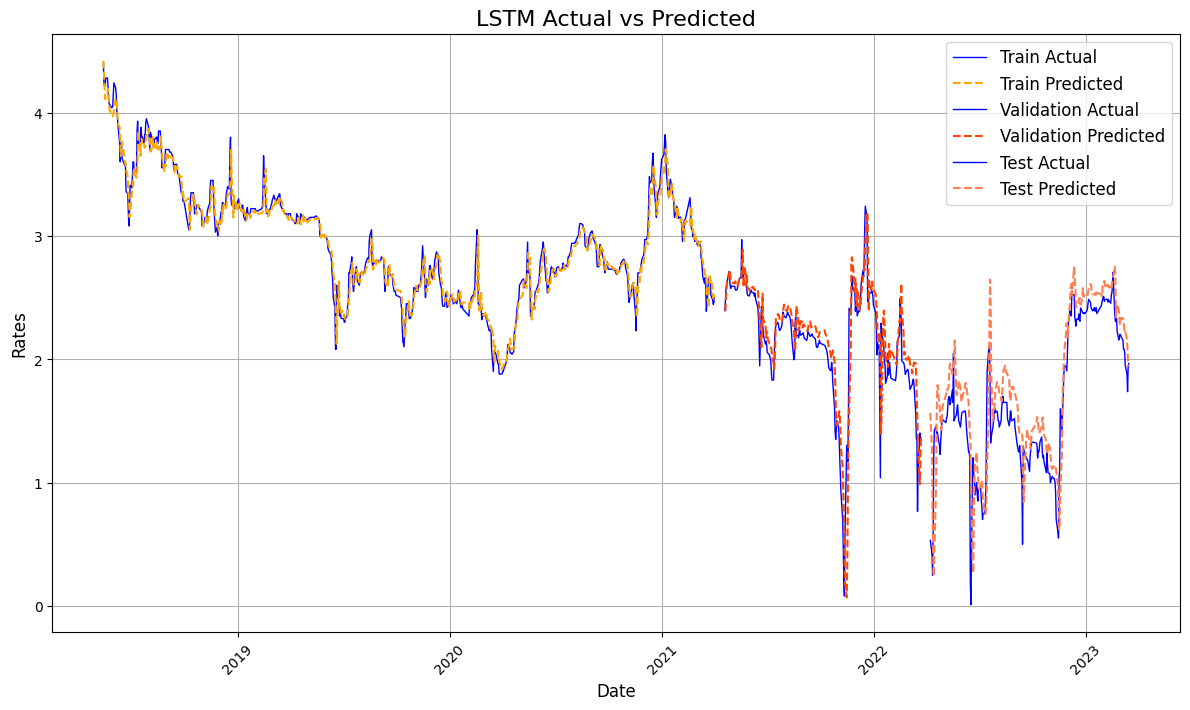

In [77]:
# Invert the scaling of predictions and actual values
base_train_predictions_inv = scaler_target.inverse_transform(base_train_predictions)
base_val_predictions_inv = scaler_target.inverse_transform(base_val_predictions)
base_test_predictions_inv = scaler_target.inverse_transform(base_test_predictions)

# Plotting the actual and predicted values
plt.figure(figsize=(12, 7))

# Train set
plt.plot(train_date_axis, y_train_inv, color='blue', linewidth=1, label='Train Actual')
plt.plot(train_date_axis, base_train_predictions_inv, color='orange', linestyle='dashed', label='Train Predicted')

# Validation set
plt.plot(val_date_axis, y_val_inv, color='blue', linewidth=1, label='Validation Actual')
plt.plot(val_date_axis, base_val_predictions_inv, color='orangered', linestyle='dashed', label='Validation Predicted')

# Test set
plt.plot(test_date_axis, y_test_inv, color='blue', linewidth=1, label='Test Actual')
plt.plot(test_date_axis, base_test_predictions_inv, color='coral', linestyle='dashed', label='Test Predicted')

plt.xlabel('Date', fontsize=12)
plt.ylabel('Rates', fontsize=12)
plt.title('LSTM Actual vs Predicted', fontsize=16)
plt.legend(fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.xticks(rotation=45)  # Rotate the x-axis labels for better visibility
plt.show()

In [97]:
data = {'Index': test_date_axis,'T+30 Acutual': y_test_inv.flatten(),'Prediction': base_test_predictions_inv.flatten()}
df = pd.DataFrame(data)
df

,Index,T+30 Acutual,Prediction
0,2022-04-08,0.532,1.564299
1,2022-04-11,0.419,1.257508
2,2022-04-12,0.249,0.701858
3,2022-04-13,0.617,0.397514
4,2022-04-14,1.219,0.237195
...,...,...,...
230,2023-03-10,1.950,2.222335
231,2023-03-13,1.882,2.165170
232,2023-03-14,1.737,2.058756
233,2023-03-15,1.936,1.974499


In [98]:
# Save to a CSV file
csv_filename = 'predictions30val.csv'
df.to_csv(csv_filename, index=False)

# Initiate the download
files.download(csv_filename)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Double Layer LSTM

In [78]:
model_lstm = Sequential()
model_lstm.add(LSTM(100, return_sequences=True, input_shape=(look_back, N)))
model_lstm.add(LSTM(50)) # Additional LSTM layer
model_lstm.add(Dropout(0.2))
model_lstm.add(Dense(1))
model_lstm.compile(optimizer='adam', loss='mse')

# Train the model using the training generator and validate using the validation generator
model_lstm.fit(train_generator, validation_data=val_generator, epochs=200)

Epoch 1/200
121/121 [==============================] - 6s 17ms/step - loss: 0.0087 - val_loss: 0.0142
Epoch 2/200
121/121 [==============================] - 1s 10ms/step - loss: 0.0064 - val_loss: 0.0138
Epoch 3/200
121/121 [==============================] - 3s 22ms/step - loss: 0.0047 - val_loss: 0.0135
Epoch 4/200
121/121 [==============================] - 1s 11ms/step - loss: 0.0052 - val_loss: 0.0139
Epoch 5/200
121/121 [==============================] - 1s 12ms/step - loss: 0.0048 - val_loss: 0.0154
Epoch 6/200
121/121 [==============================] - 2s 13ms/step - loss: 0.0053 - val_loss: 0.0126
Epoch 7/200
121/121 [==============================] - 2s 15ms/step - loss: 0.0046 - val_loss: 0.0128
Epoch 8/200
121/121 [==============================] - 2s 17ms/step - loss: 0.0042 - val_loss: 0.0121
Epoch 9/200
121/121 [==============================] - 2s 17ms/step - loss: 0.0042 - val_loss: 0.0124
Epoch 10/200
121/121 [==============================] - 1s 11ms/step - loss: 0.003

In [79]:
lstm_train_predictions = model_lstm.predict(train_generator)
lstm_val_predictions = model_lstm.predict(val_generator)
lstm_test_predictions = model_lstm.predict(test_generator)

lstm_train_rmse = np.sqrt(mean_squared_error(y_train_scaled[look_back:], lstm_train_predictions))
lstm_val_rmse = np.sqrt(mean_squared_error(y_val_scaled[look_back:], lstm_val_predictions))
lstm_test_rmse = np.sqrt(mean_squared_error(y_test_scaled[look_back:], lstm_test_predictions))

40/40 [==============================] - 0s 3ms/step


In [80]:
lstm_rmse_df = pd.DataFrame({
    'Dataset': ['Train', 'Validation', 'Test'],
    'RMSE': [lstm_train_rmse, lstm_val_rmse, lstm_test_rmse]
})

print(lstm_rmse_df)

      Dataset      RMSE
0       Train  0.025940
1  Validation  0.087524
2        Test  0.129934


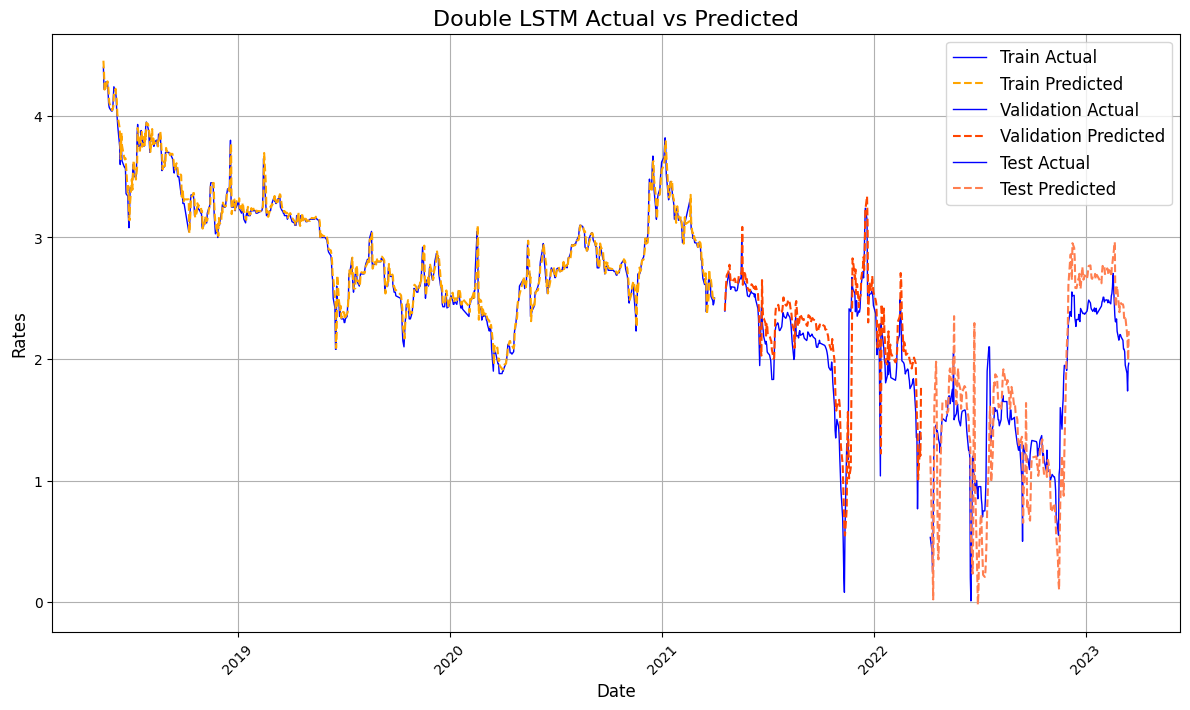

In [81]:
# Invert the scaling of predictions and actual values
lstm_train_predictions_inv = scaler_target.inverse_transform(lstm_train_predictions)
lstm_val_predictions_inv = scaler_target.inverse_transform(lstm_val_predictions)
lstm_test_predictions_inv = scaler_target.inverse_transform(lstm_test_predictions)

# Plotting the actual and predicted values
plt.figure(figsize=(12, 7))

# Train set
plt.plot(train_date_axis, y_train_inv, color='blue', linewidth=1, label='Train Actual')
plt.plot(train_date_axis, lstm_train_predictions_inv, color='orange', linestyle='dashed', label='Train Predicted')

# Validation set
plt.plot(val_date_axis, y_val_inv, color='blue', linewidth=1, label='Validation Actual')
plt.plot(val_date_axis, lstm_val_predictions_inv, color='orangered', linestyle='dashed', label='Validation Predicted')

# Test set
plt.plot(test_date_axis, y_test_inv, color='blue', linewidth=1, label='Test Actual')
plt.plot(test_date_axis, lstm_test_predictions_inv, color='coral', linestyle='dashed', label='Test Predicted')

plt.xlabel('Date', fontsize=12)
plt.ylabel('Rates', fontsize=12)
plt.title('Double LSTM Actual vs Predicted', fontsize=16)
plt.legend(fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.xticks(rotation=45)  # Rotate the x-axis labels for better visibility
plt.show()


## GRU

In [82]:
from keras.layers import GRU

model_gru = Sequential()
model_gru.add(GRU(100, return_sequences=True, input_shape=(look_back, N)))
model_gru.add(GRU(50))
model_gru.add(Dropout(0.2))
model_gru.add(Dense(1))
model_gru.compile(optimizer='adam', loss='mse')

# Train the model using the training generator and validate using the validation generator
model_gru.fit(train_generator, validation_data=val_generator, epochs=200)

Epoch 1/200
121/121 [==============================] - 7s 19ms/step - loss: 0.0102 - val_loss: 0.0117
Epoch 2/200
121/121 [==============================] - 1s 11ms/step - loss: 0.0059 - val_loss: 0.0141
Epoch 3/200
121/121 [==============================] - 2s 17ms/step - loss: 0.0058 - val_loss: 0.0178
Epoch 4/200
121/121 [==============================] - 1s 12ms/step - loss: 0.0053 - val_loss: 0.0109
Epoch 5/200
121/121 [==============================] - 1s 11ms/step - loss: 0.0041 - val_loss: 0.0097
Epoch 6/200
121/121 [==============================] - 1s 11ms/step - loss: 0.0042 - val_loss: 0.0099
Epoch 7/200
121/121 [==============================] - 1s 11ms/step - loss: 0.0050 - val_loss: 0.0093
Epoch 8/200
121/121 [==============================] - 1s 11ms/step - loss: 0.0041 - val_loss: 0.0103
Epoch 9/200
121/121 [==============================] - 3s 25ms/step - loss: 0.0037 - val_loss: 0.0093
Epoch 10/200
121/121 [==============================] - 2s 15ms/step - loss: 0.004

In [83]:
gru_train_predictions = model_gru.predict(train_generator)
gru_val_predictions = model_gru.predict(val_generator)
gru_test_predictions = model_gru.predict(test_generator)

gru_train_rmse = np.sqrt(mean_squared_error(y_train_scaled[look_back:], gru_train_predictions))
gru_val_rmse = np.sqrt(mean_squared_error(y_val_scaled[look_back:], gru_val_predictions))
gru_test_rmse = np.sqrt(mean_squared_error(y_test_scaled[look_back:], gru_test_predictions))

40/40 [==============================] - 0s 3ms/step


In [84]:
gru_rmse_df = pd.DataFrame({
    'Dataset': ['Train', 'Validation', 'Test'],
    'RMSE': [gru_train_rmse, gru_val_rmse, gru_test_rmse]
})

print(gru_rmse_df)

      Dataset      RMSE
0       Train  0.029098
1  Validation  0.115204
2        Test  0.184300


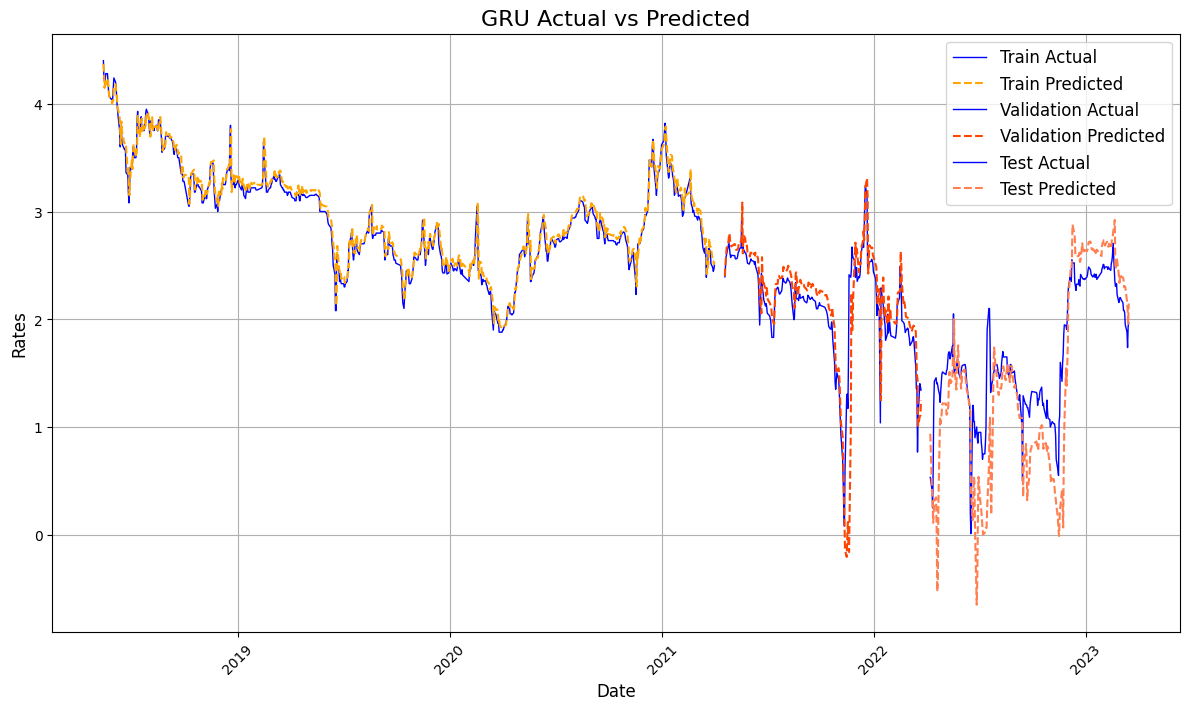

In [85]:
# Invert the scaling of predictions and actual values
gru_train_predictions_inv = scaler_target.inverse_transform(gru_train_predictions)
gru_val_predictions_inv = scaler_target.inverse_transform(gru_val_predictions)
gru_test_predictions_inv = scaler_target.inverse_transform(gru_test_predictions)

# Plotting the actual and predicted values
plt.figure(figsize=(12, 7))

# Train set
plt.plot(train_date_axis, y_train_inv, color='blue', linewidth=1, label='Train Actual')
plt.plot(train_date_axis, gru_train_predictions_inv, color='orange', linestyle='dashed', label='Train Predicted')

# Validation set
plt.plot(val_date_axis, y_val_inv, color='blue', linewidth=1, label='Validation Actual')
plt.plot(val_date_axis, gru_val_predictions_inv, color='orangered', linestyle='dashed', label='Validation Predicted')

# Test set
plt.plot(test_date_axis, y_test_inv, color='blue', linewidth=1, label='Test Actual')
plt.plot(test_date_axis, gru_test_predictions_inv, color='coral', linestyle='dashed', label='Test Predicted')

plt.xlabel('Date', fontsize=12)
plt.ylabel('Rates', fontsize=12)
plt.title('GRU Actual vs Predicted', fontsize=16)
plt.legend(fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.xticks(rotation=45)  # Rotate the x-axis labels for better visibility
plt.show()


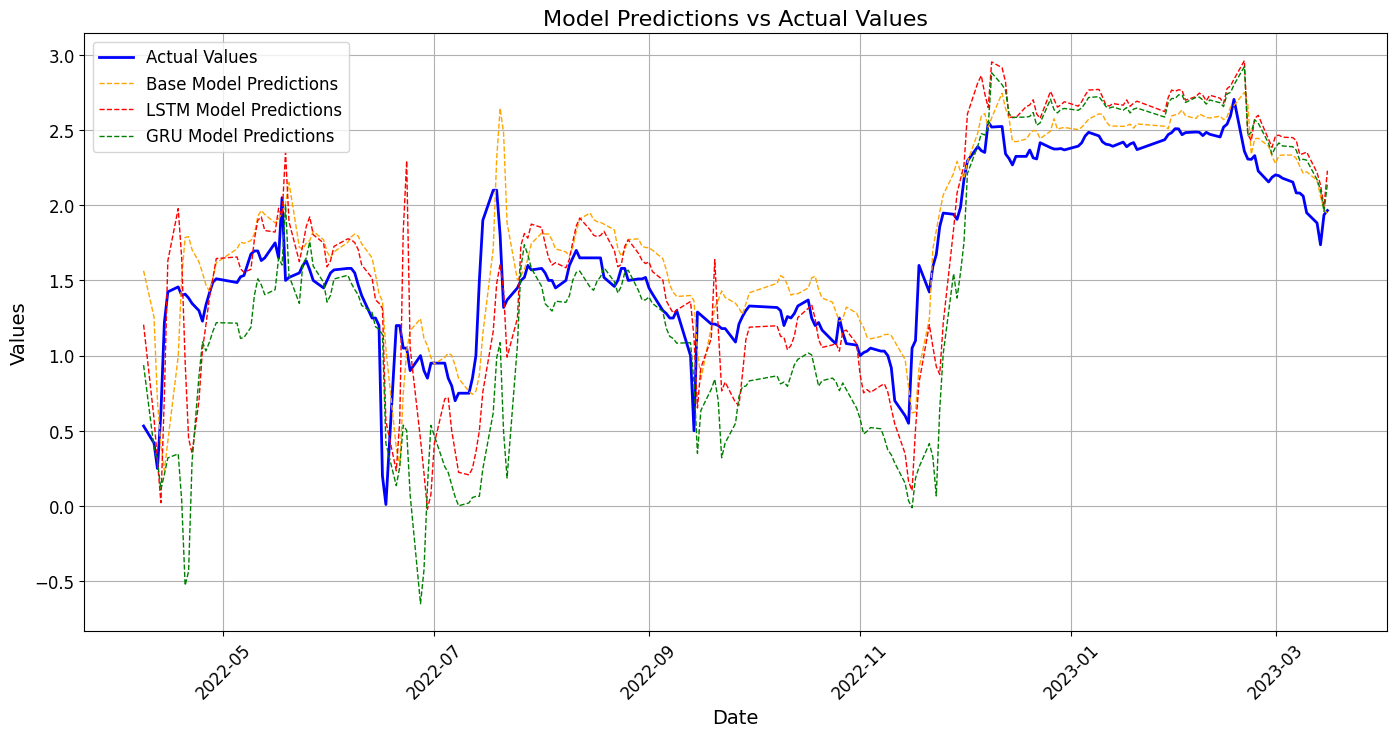

In [86]:
plt.figure(figsize=(14, 7))

# Plot the actual values
plt.plot(test_date_axis, y_test_inv, color='blue', linewidth=2, label='Actual Values')

# Plot the predictions from the base model
plt.plot(test_date_axis, base_test_predictions_inv, color='orange', linestyle='dashed', linewidth=1, label='Base Model Predictions')

# Plot the predictions from the LSTM model
plt.plot(test_date_axis, lstm_test_predictions_inv, color='red', linestyle='dashed', linewidth=1, label='LSTM Model Predictions')

# Plot the predictions from the GRU model
plt.plot(test_date_axis, gru_test_predictions_inv, color='green', linestyle='dashed', linewidth=1, label='GRU Model Predictions')

# Adding labels and title
plt.xlabel('Date', fontsize=14)
plt.ylabel('Values', fontsize=14)
plt.title('Model Predictions vs Actual Values', fontsize=16)

# Adding a legend to differentiate between the lines
plt.legend(fontsize=12)

# Display the plot
plt.grid(True)
plt.tight_layout()
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.show()
